# Deep Learning Course MVA (Instructor: Vincent Lepetit)


# Project: Image Classification and Regression


## Rq: see "comments" cells for the comments

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf

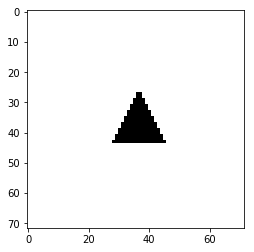

In [2]:
### Basic functions 


# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0,denoising=False):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noisy = imdata + noise * np.random.random(imdata.size)
    if denoising:
        plt.close(fig)
        return [imdata, imdata_noisy]
    else:
        plt.close(fig)
        return imdata

def generate_a_rectangle(noise=0.0, free_location=False,denoising=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise,denoising)


def generate_a_disk(noise=0.0, free_location=False,denoising=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise,denoising)

def generate_a_triangle(noise=0.0, free_location=False,denoising=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise,denoising)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 100 == 0:
         #   print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 100 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            Y[i],X[i] = generate_a_rectangle(noise, free_location,denoising=True)
        elif category == 1: 
            Y[i],X[i] = generate_a_disk(noise, free_location,denoising=True)
        else:
            [[Y[i],X[i]], V] = generate_a_triangle(noise, free_location,denoising=True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = tf.keras.utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 100 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



## Simple Classification

In [19]:
# Create the trainset 
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = tf.keras.utils.to_categorical(Y_train)
[X_test, Y_test] = generate_dataset_classification(300, 20)
Y_test = tf.keras.utils.to_categorical(Y_test)

Creating data:
Creating data:


In [25]:
# Linear classifier trained with SGD 
model_sgd = tf.keras.Sequential()
model_sgd.add(tf.keras.layers.Dense(3, activation='softmax'))

model_sgd.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

hist = model_sgd.fit(X_train, Y_train, epochs=30, batch_size=32,validation_data=(X_test, Y_test))

Train on 300 samples, validate on 300 samples
Epoch 1/30
300/300 [==============================] - 1s 3ms/step - loss: 1.3319 - categorical_accuracy: 0.1533 - val_loss: 1.3235 - val_categorical_accuracy: 0.3367
Epoch 2/30
300/300 [==============================] - 0s 393us/step - loss: 1.1624 - categorical_accuracy: 0.3600 - val_loss: 1.1072 - val_categorical_accuracy: 0.3900
Epoch 3/30
300/300 [==============================] - 0s 587us/step - loss: 0.9790 - categorical_accuracy: 0.5200 - val_loss: 1.0778 - val_categorical_accuracy: 0.3233
Epoch 4/30
300/300 [==============================] - 0s 471us/step - loss: 0.9266 - categorical_accuracy: 0.6367 - val_loss: 0.8501 - val_categorical_accuracy: 0.6433
Epoch 5/30
300/300 [==============================] - 0s 2ms/step - loss: 0.8428 - categorical_accuracy: 0.6567 - val_loss: 0.7965 - val_categorical_accuracy: 0.6633
Epoch 6/30
300/300 [==============================] - 0s 230us/step - loss: 0.7844 - categorical_accuracy: 0.7300 - va

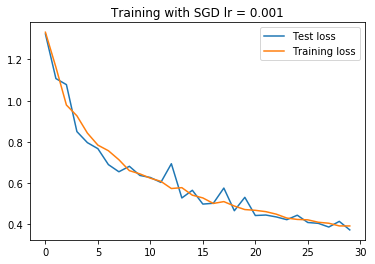

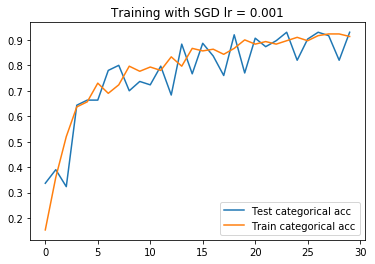

In [27]:
plt.plot(hist.history['val_loss'],label="Test loss")
plt.plot(hist.history['loss'],label="Training loss")
plt.legend(loc="best")
plt.title("Training with SGD lr = 0.001")
plt.show()

plt.plot(hist.history['val_categorical_accuracy'],label="Test categorical acc")
plt.plot(hist.history['categorical_accuracy'],label="Train categorical acc")
plt.legend(loc="best")
plt.title("Training with SGD lr = 0.001")
plt.show()


In [33]:
# Linear classifier trained with Adam optimizer
model_adam = tf.keras.Sequential()
model_adam.add(tf.keras.layers.Dense(3, activation='softmax'))

model_adam.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

hist_adam = model_adam.fit(X_train, Y_train, epochs=20, batch_size=32,validation_data=(X_test, Y_test))

Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 1s 4ms/step - loss: 1.4980 - categorical_accuracy: 0.4533 - val_loss: 1.0519 - val_categorical_accuracy: 0.5967
Epoch 2/20
300/300 [==============================] - 0s 198us/step - loss: 0.7499 - categorical_accuracy: 0.6633 - val_loss: 0.5859 - val_categorical_accuracy: 0.8000
Epoch 3/20
300/300 [==============================] - 0s 203us/step - loss: 0.5358 - categorical_accuracy: 0.7767 - val_loss: 0.6756 - val_categorical_accuracy: 0.6767
Epoch 4/20
300/300 [==============================] - 0s 263us/step - loss: 0.4559 - categorical_accuracy: 0.7967 - val_loss: 0.3985 - val_categorical_accuracy: 0.8000
Epoch 5/20
300/300 [==============================] - 0s 128us/step - loss: 0.3167 - categorical_accuracy: 0.9267 - val_loss: 0.3819 - val_categorical_accuracy: 0.7900
Epoch 6/20
300/300 [==============================] - 0s 165us/step - loss: 0.3101 - categorical_accuracy: 0.8533 - 

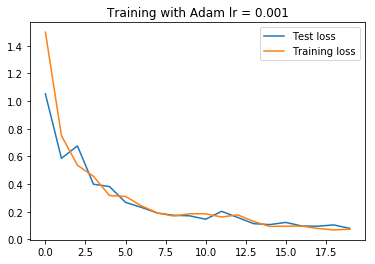

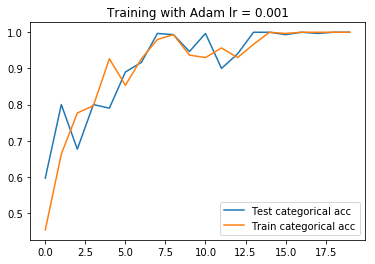

In [34]:
plt.plot(hist_adam.history['val_loss'],label="Test loss")
plt.plot(hist_adam.history['loss'],label="Training loss")
plt.legend(loc="best")
plt.title("Training with Adam lr = 0.001")
plt.show()

plt.plot(hist_adam.history['val_categorical_accuracy'],label="Test categorical acc")
plt.plot(hist_adam.history['categorical_accuracy'],label="Train categorical acc")
plt.legend(loc="best")
plt.title("Training with Adam lr = 0.001")
plt.show()


# Comments:

- Both optimize converge with a learning rate = 0.001 to a near perfect accuracy
- With a **learning rate higher than 0.001**, the optimizer have trouble to converge.

## Visualisation of the Solution

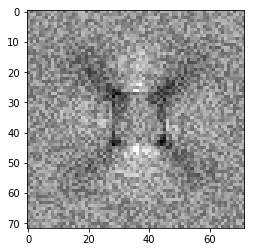

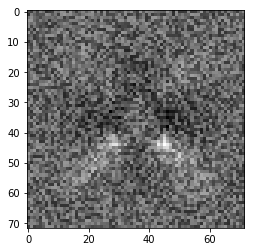

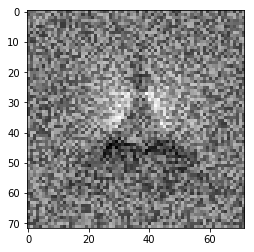

In [32]:
plt.imshow(model_adam.get_weights()[0][:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(model_adam.get_weights()[0][:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(model_adam.get_weights()[0][:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

# Comments

- We can see that **each column detects one geometric shape at a specific place in the image**. Example: the firs column detects square and will have a high response for images that have a square at the center of the image.

## 5. A More Difficult Classification Problem: free location of the geometric shapes

In [35]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train = tf.keras.utils.to_categorical(Y_train)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
Creating data:


In [60]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

hist = model.fit(X_train, Y_train, epochs=100, batch_size=32,validation_data=(X_test, Y_test))



Train on 1000 samples, validate on 300 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 1.4219 - categorical_accuracy: 0.4240 - val_loss: 1.0220 - val_categorical_accuracy: 0.4733
Epoch 2/100
1000/1000 [==============================] - 0s 359us/step - loss: 1.0785 - categorical_accuracy: 0.4880 - val_loss: 0.9928 - val_categorical_accuracy: 0.5667
Epoch 3/100
1000/1000 [==============================] - 0s 106us/step - loss: 0.9695 - categorical_accuracy: 0.5220 - val_loss: 0.9573 - val_categorical_accuracy: 0.5267
Epoch 4/100
1000/1000 [==============================] - 0s 140us/step - loss: 0.9698 - categorical_accuracy: 0.5420 - val_loss: 0.9467 - val_categorical_accuracy: 0.5333
Epoch 5/100
1000/1000 [==============================] - 0s 173us/step - loss: 0.8735 - categorical_accuracy: 0.5810 - val_loss: 0.9650 - val_categorical_accuracy: 0.5500
Epoch 6/100
1000/1000 [==============================] - 0s 152us/step - loss: 0.9746 - categorical_

1000/1000 [==============================] - 0s 164us/step - loss: 0.7573 - categorical_accuracy: 0.6640 - val_loss: 0.9243 - val_categorical_accuracy: 0.5967
Epoch 49/100
1000/1000 [==============================] - 0s 104us/step - loss: 0.6876 - categorical_accuracy: 0.6760 - val_loss: 0.7571 - val_categorical_accuracy: 0.6300
Epoch 50/100
1000/1000 [==============================] - 0s 133us/step - loss: 0.5720 - categorical_accuracy: 0.7600 - val_loss: 0.7985 - val_categorical_accuracy: 0.6233
Epoch 51/100
1000/1000 [==============================] - 0s 165us/step - loss: 0.5702 - categorical_accuracy: 0.7400 - val_loss: 1.0807 - val_categorical_accuracy: 0.6167
Epoch 52/100
1000/1000 [==============================] - 0s 85us/step - loss: 0.6116 - categorical_accuracy: 0.7230 - val_loss: 0.8174 - val_categorical_accuracy: 0.6067
Epoch 53/100
1000/1000 [==============================] - 0s 108us/step - loss: 0.6788 - categorical_accuracy: 0.6740 - val_loss: 0.7874 - val_categorical

Epoch 96/100
1000/1000 [==============================] - 0s 195us/step - loss: 0.5234 - categorical_accuracy: 0.7460 - val_loss: 0.9676 - val_categorical_accuracy: 0.5667
Epoch 97/100
1000/1000 [==============================] - 0s 95us/step - loss: 0.5694 - categorical_accuracy: 0.7320 - val_loss: 1.0020 - val_categorical_accuracy: 0.6133
Epoch 98/100
1000/1000 [==============================] - 0s 104us/step - loss: 0.4877 - categorical_accuracy: 0.7970 - val_loss: 1.0583 - val_categorical_accuracy: 0.5967
Epoch 99/100
1000/1000 [==============================] - 0s 124us/step - loss: 0.5361 - categorical_accuracy: 0.7440 - val_loss: 0.8216 - val_categorical_accuracy: 0.6267
Epoch 100/100
1000/1000 [==============================] - 0s 109us/step - loss: 0.4410 - categorical_accuracy: 0.8230 - val_loss: 0.7712 - val_categorical_accuracy: 0.6400


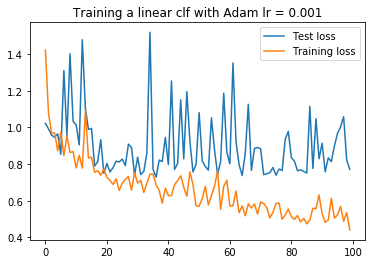

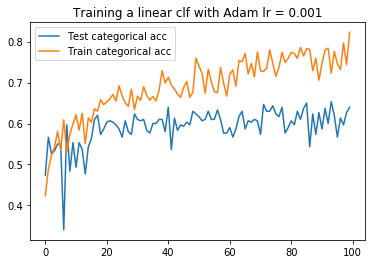

In [62]:
plt.plot(hist.history['val_loss'],label="Test loss")
plt.plot(hist.history['loss'],label="Training loss")
plt.legend(loc="best")
plt.title("Training a linear clf with Adam lr = 0.001")
plt.show()

plt.plot(hist.history['val_categorical_accuracy'],label="Test categorical acc")
plt.plot(hist.history['categorical_accuracy'],label="Train categorical acc")
plt.legend(loc="best")
plt.title("Training a linear clf with Adam lr = 0.001")
plt.show()


In [58]:
# shallow CNN
model_conv = tf.keras.Sequential()
model_conv.add(tf.keras.layers.Conv2D(filters=16,kernel_size=5))#,activation='relu'))
model_conv.add(tf.keras.layers.MaxPooling2D((3, 3), padding='same'))
model_conv.add(tf.keras.layers.Flatten())
# Adds a densely-connected layer with 3 units to the model:
model_conv.add(tf.keras.layers.Dense(3, activation='softmax'))

model_conv.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

# Reshape X_train => [num_samples,nlin,ncol,channels]
X_train_im = X_train.reshape(X_train.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
X_test_im = X_test.reshape(X_test.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)

hist_conv = model_conv.fit(X_train_im, Y_train, epochs=50, batch_size=32,validation_data=(X_test_im, Y_test))





Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 6s 6ms/step - loss: 1.0667 - categorical_accuracy: 0.5060 - val_loss: 0.9169 - val_categorical_accuracy: 0.6367
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.8354 - categorical_accuracy: 0.6510 - val_loss: 0.8305 - val_categorical_accuracy: 0.6000
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7119 - categorical_accuracy: 0.7200 - val_loss: 0.7470 - val_categorical_accuracy: 0.6333
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6258 - categorical_accuracy: 0.7640 - val_loss: 0.6311 - val_categorical_accuracy: 0.7800
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5833 - categorical_accuracy: 0.7900 - val_loss: 0.6963 - val_categorical_accuracy: 0.6600
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5303 - categorical_accuracy: 0.8020

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0477 - categorical_accuracy: 0.9980 - val_loss: 0.3737 - val_categorical_accuracy: 0.8733
Epoch 50/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0420 - categorical_accuracy: 0.9980 - val_loss: 0.3298 - val_categorical_accuracy: 0.8800


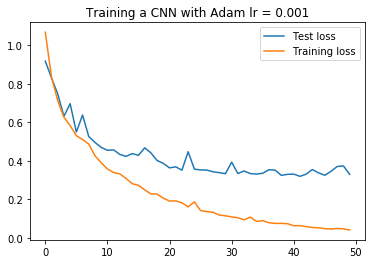

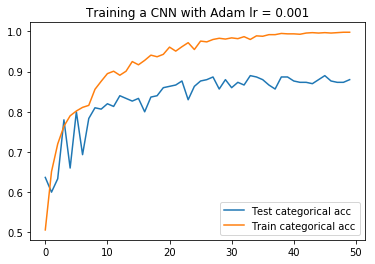

In [63]:
plt.plot(hist_conv.history['val_loss'],label="Test loss")
plt.plot(hist_conv.history['loss'],label="Training loss")
plt.legend(loc="best")
plt.title("Training a CNN with Adam lr = 0.001")
plt.show()

plt.plot(hist_conv.history['val_categorical_accuracy'],label="Test categorical acc")
plt.plot(hist_conv.history['categorical_accuracy'],label="Train categorical acc")
plt.legend(loc="best")
plt.title("Training a CNN with Adam lr = 0.001")
plt.show()


# Comments: free localisation=True

- For linear classifier is not able to exceed ~0.55 accuracy. The plot suggests that the linear classifier may have overfitted the data as one can see big jumps in the test loss. This linear classifier is not build to detect local invariance. 
- The CNN classifier does learn to classify correctly. **Conv layers enforce locality and translation invariance which is very useful here.**


# 6. A Regression Problem

In [69]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)
[X_test, Y_test] = generate_test_set_regression()
# Reshape X_train => [num_samples,nlin,ncol,channels]
X_train_im = X_train.reshape(X_train.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
X_test_im = X_test.reshape(X_test.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)

Creating data:
Creating data:


In [102]:
#visualize_prediction(X_test[3], Y_test[3])
Y_train_norm = (Y_train-Y_train.mean(axis=0))/Y_train.std(axis=0)
Y_test_norm = (Y_test-Y_train.mean(axis=0))/Y_train.std(axis=0)

In [75]:
# shallow CNN
model_conv = tf.keras.Sequential()
model_conv.add(tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation='relu'))
model_conv.add(tf.keras.layers.MaxPooling2D((3, 3), padding='same'))
model_conv.add(tf.keras.layers.Flatten())
# Adds a densely-connected layer with 6 units to the model:
model_conv.add(tf.keras.layers.Dense(6))

model_conv.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),
              loss=tf.keras.losses.mean_squared_error)

# Reshape X_train => [num_samples,nlin,ncol,channels]
X_train_im = X_train.reshape(X_train.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
X_test_im = X_test.reshape(X_test.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)

hist_conv = model_conv.fit(X_train_im, Y_train, epochs=20, batch_size=32,validation_data=(X_test_im, Y_test))



Train on 3000 samples, validate on 300 samples
Epoch 1/20
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0922 - val_loss: 0.0810
Epoch 2/20
3000/3000 [==============================] - 7s 2ms/step - loss: 0.0796 - val_loss: 0.0742
Epoch 3/20
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0749 - val_loss: 0.0720
Epoch 4/20
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0719 - val_loss: 0.0699
Epoch 5/20
3000/3000 [==============================] - 7s 2ms/step - loss: 0.0698 - val_loss: 0.0679
Epoch 6/20
3000/3000 [==============================] - 7s 2ms/step - loss: 0.0679 - val_loss: 0.0693
Epoch 7/20
3000/3000 [==============================] - 7s 2ms/step - loss: 0.0666 - val_loss: 0.0668
Epoch 8/20
3000/3000 [==============================] - 8s 3ms/step - loss: 0.0656 - val_loss: 0.0663
Epoch 9/20
3000/3000 [==============================] - 7s 2ms/step - loss: 0.0648 - val_loss: 0.0642
Epoch 10/20
3000/3000 [============

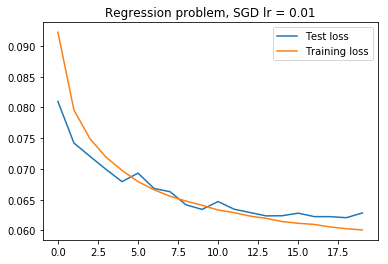

In [79]:
plt.plot(hist_conv.history['val_loss'],label="Test loss")
plt.plot(hist_conv.history['loss'],label="Training loss")
plt.legend(loc="best")
plt.title("Regression problem, SGD lr = 0.01")
plt.show()



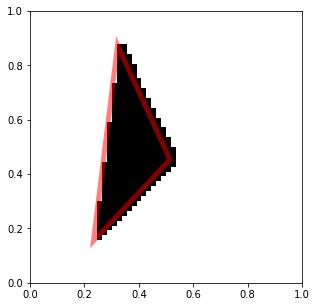

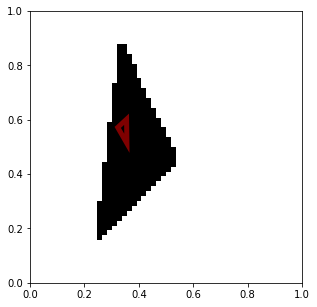

In [84]:
visualize_prediction(X_test[2], Y_test[2])
visualize_prediction(X_test[2], model_conv.predict(X_test_im)[2])

# Comments for the regression problem

- Even with a normalisation (zero mean / var = 1), the results are not very good.
- SGD was used here as with Adam in this setup the CNN tends to overfit the data.

# 7. Image Denoising

In [9]:
[X_train, Y_train] = generate_dataset_denoising(1000, 20)
#Y_train = X_train[0] # image without noise
#X_train = X_train[1] # image with noise
[X_test, Y_test] = generate_dataset_denoising(300,20)
# Reshape X_train => [num_samples,nlin,ncol,channels]
X_train_im = X_train.reshape(X_train.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
Y_train_im = Y_train.reshape(Y_train.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
X_test_im = X_test.reshape(X_test.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
Y_test_im = Y_test.reshape(Y_test.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)

Creating data:
Creating data:


In [28]:
# Hourglass network for image denoising (AE)
model_ae = tf.keras.Sequential()
# Encoder
model_ae.add(tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation='relu'))
model_ae.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
model_ae.add(tf.keras.layers.Conv2D(filters=8,kernel_size=3,activation='relu'))
model_ae.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
# Decoder
model_ae.add(tf.keras.layers.Conv2D(filters=8,kernel_size=3,activation='relu'))
model_ae.add(tf.keras.layers.UpSampling2D((2, 2)))
model_ae.add(tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation='relu'))
model_ae.add(tf.keras.layers.UpSampling2D())
model_ae.add(tf.keras.layers.Conv2D(filters=16,kernel_size=7,activation='relu'))
model_ae.add(tf.keras.layers.Flatten())
model_ae.add(tf.keras.layers.Dense(IMAGE_SIZE*IMAGE_SIZE))
#model_ae.add(tf.keras.layers.Conv2D(filters=1,kernel_size=7))
#model_ae.add(tf.keras.layers.UpSampling2D())

model_ae.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.mean_squared_error)


hist_ae = model_ae.fit(X_train_im, Y_train, epochs=50, batch_size=32,validation_data=(X_test_im, Y_test))



Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 22s 22ms/step - loss: 18504.8124 - val_loss: 5825.3670
Epoch 2/50
1000/1000 [==============================] - 18s 18ms/step - loss: 4280.4765 - val_loss: 3137.1193
Epoch 3/50
1000/1000 [==============================] - 19s 19ms/step - loss: 2441.8569 - val_loss: 1915.5935
Epoch 4/50
1000/1000 [==============================] - 18s 18ms/step - loss: 1682.2806 - val_loss: 1465.2268
Epoch 5/50
1000/1000 [==============================] - 18s 18ms/step - loss: 1381.5683 - val_loss: 1330.1236
Epoch 6/50
1000/1000 [==============================] - 19s 19ms/step - loss: 1249.3699 - val_loss: 1211.7572
Epoch 7/50
1000/1000 [==============================] - 19s 19ms/step - loss: 1133.9239 - val_loss: 1076.1487
Epoch 8/50
1000/1000 [==============================] - 18s 18ms/step - loss: 1040.7229 - val_loss: 1008.4886
Epoch 9/50
1000/1000 [==============================] - 18s 18ms/step - 

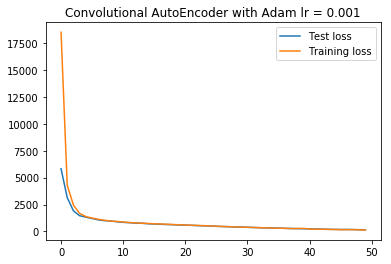

In [37]:
plt.plot(hist_ae.history['val_loss'],label="Test loss")
plt.plot(hist_ae.history['loss'],label="Training loss")
plt.legend(loc="best")
plt.title("Convolutional AutoEncoder with Adam lr = 0.001")
plt.show()



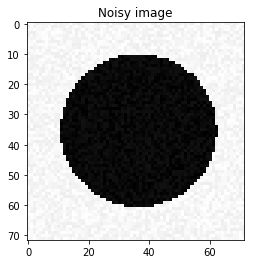

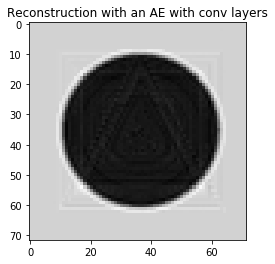

In [49]:
plt.imshow(X_test_im[4].reshape(72,72),cmap='gray')
plt.title("Noisy image")
plt.show()
plt.imshow(model_ae.predict(X_test_im)[4].reshape(72,72),cmap='gray')
plt.title("Reconstruction with an AE with conv layers")
plt.show()

# Comments : image denoising

- An autoencoder is here used to retrieve the image without noise. 
- The encoder part shrinks the dimension of the image whereas the decoder part output an image with the same dimension as the input image.
- The training does converge however the presence of the fully connected layer makes the geometric shapes visible.
- The Conv AE and the AE have similar performances.

In [41]:
# Hourglass network for image denoising (AE) with only fully connected layers 
model_a = tf.keras.Sequential()
# Encoder
#model_a.add(tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation='relu'))
#model_a.add(tf.keras.layers.Flatten())
# Adds a densely-connected layer with 6 units to the model:
model_a.add(tf.keras.layers.Dense(128,activation='relu'))
model_a.add(tf.keras.layers.Dense(64,activation='relu'))
model_a.add(tf.keras.layers.Dense(32,activation='relu'))
model_a.add(tf.keras.layers.Dense(64,activation='relu'))
model_a.add(tf.keras.layers.Dense(128,activation='relu'))
model_a.add(tf.keras.layers.Dense(IMAGE_SIZE*IMAGE_SIZE))

model_a.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss=tf.keras.losses.mean_squared_error)


hist_a = model_a.fit(X_train, Y_train, epochs=100, batch_size=32,validation_data=(X_test, Y_test))


Train on 1000 samples, validate on 300 samples
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 17960.8980 - val_loss: 6233.0953
Epoch 2/100
1000/1000 [==============================] - 1s 763us/step - loss: 4993.4985 - val_loss: 4848.6257
Epoch 3/100
1000/1000 [==============================] - 1s 829us/step - loss: 4733.1326 - val_loss: 4821.3284
Epoch 4/100
1000/1000 [==============================] - 1s 845us/step - loss: 4713.3686 - val_loss: 4802.4012
Epoch 5/100
1000/1000 [==============================] - 1s 1ms/step - loss: 4712.3588 - val_loss: 4833.3145
Epoch 6/100
1000/1000 [==============================] - 1s 694us/step - loss: 4721.0501 - val_loss: 4781.2117
Epoch 7/100
1000/1000 [==============================] - 1s 986us/step - loss: 4687.0419 - val_loss: 4707.1851
Epoch 8/100
1000/1000 [==============================] - 1s 701us/step - loss: 3722.8670 - val_loss: 2818.0416
Epoch 9/100
1000/1000 [==============================] - 1s 688us/st

1000/1000 [==============================] - 1s 662us/step - loss: 1625.2640 - val_loss: 710.3589
Epoch 76/100
1000/1000 [==============================] - 1s 995us/step - loss: 636.9040 - val_loss: 483.4031
Epoch 77/100
1000/1000 [==============================] - 1s 740us/step - loss: 452.5532 - val_loss: 435.1987
Epoch 78/100
1000/1000 [==============================] - 1s 797us/step - loss: 425.5797 - val_loss: 410.1449
Epoch 79/100
1000/1000 [==============================] - 1s 917us/step - loss: 413.8179 - val_loss: 416.7208
Epoch 80/100
1000/1000 [==============================] - 1s 943us/step - loss: 402.2631 - val_loss: 389.7016
Epoch 81/100
1000/1000 [==============================] - 1s 926us/step - loss: 390.5379 - val_loss: 391.2977
Epoch 82/100
1000/1000 [==============================] - 1s 1ms/step - loss: 383.0732 - val_loss: 384.4196
Epoch 83/100
1000/1000 [==============================] - 1s 970us/step - loss: 377.9015 - val_loss: 380.6307
Epoch 84/100
1000/1000 [

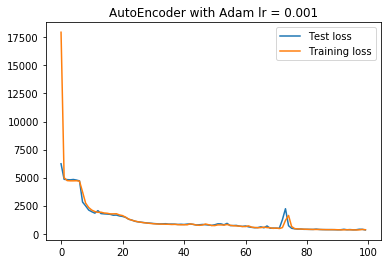

In [42]:
plt.plot(hist_a.history['val_loss'],label="Test loss")
plt.plot(hist_a.history['loss'],label="Training loss")
plt.legend(loc="best")
plt.title("AutoEncoder with Adam lr = 0.001")
plt.show()


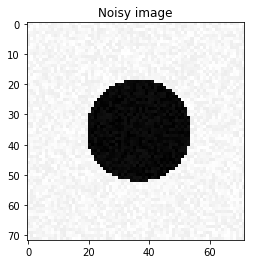

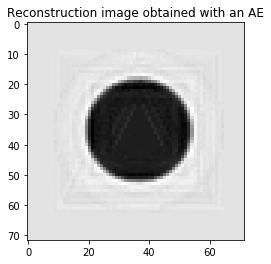

In [47]:
plt.imshow(X_test_im[0].reshape(72,72),cmap='gray')
plt.title("Noisy image")
plt.show()
plt.imshow(model_a.predict(X_test)[0].reshape(72,72),cmap='gray')
plt.title("Reconstruction image obtained with an AE")
plt.show()